<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 434 ms, sys: 1.26 s, total: 1.7 s
Wall time: 314 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.33130896 0.14439344 0.5922642  1.5023434  0.3135229  0.3517375
 0.88812923 0.73625845 0.7179545  0.34985852]

For each image there are 5 reference captions, e.g.:

closeup of bins of food that include broccoli and bread .
a meal is presented in brightly colored plastic trays .
there are containers filled with different kinds of foods
colorful dishes holding meat , vegetables , fruit , and bread .
a bunch of trays that have different food .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [5]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
word_counts = Counter([token for img in captions for caption in img for token in caption[1:-1]])

In [6]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   14,  287,  141,   14, 1130,  256,   62,   14, 1291,    2,
           3,    3,    3],
       [   1,   14,  287,   62,   14, 1130,  256,  141,   14, 1291,    2,
           3,    3,    3],
       [   1,   14,   90,  141,   14, 1291,   62,   44,    5,   14, 1287,
          13,    2,    3],
       [   1,   14, 1238, 1370,   14, 1291,   62,   14,   73,   74,   13,
           2,    3,    3],
       [   1,   14,   90,   18,   71,  342,  141,   14, 1291,   62,   14,
        1287,   13,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [10]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048, 
                 n_layers=1, dropout=0):

        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(
            num_embeddings=n_tokens,
            embedding_dim=emb_size
        )
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=lstm_units,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=False,
            batch_first=True
        )
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(
            in_features=n_layers*lstm_units,
            out_features=n_tokens
        )
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix) 
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, hidden = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [11]:
network = CaptionNet(n_tokens)

In [12]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 14, 10403])


In [13]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_ix)

In [14]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous().view(-1)
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors.to(device), captions_ix_inp.to(device))
    logits_for_next = logits_for_next.contiguous().view(-1, logits_for_next.shape[-1]).cpu()
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = criterion(logits_for_next, captions_ix_next)
    
    return loss.unsqueeze(0)

In [15]:
network.to(device)

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (logits): Linear(in_features=256, out_features=10403, bias=True)
)

In [16]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [17]:
params = [param for param in network.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(params, lr=3e-4, amsgrad=True, weight_decay=1e-6)

# Training

* First implement the batch generator
* Than train the network as usual

In [18]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

/home/andyst/anaconda3/envs/pytorch_1.5.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [19]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [20]:
generate_batch(img_codes,captions, 3)

(tensor([[0.4669, 0.1716, 0.2586,  ..., 0.0193, 0.0115, 0.7210],
         [1.3493, 0.3665, 0.5176,  ..., 0.1417, 0.0087, 0.3301],
         [0.1500, 0.3486, 0.1128,  ..., 0.6769, 0.6967, 0.5592]]),
 tensor([[   1,   14,  275,  273,  274,  616,   14,  447,   80,   27,   58,   13,
             2,    3],
         [   1,   14,   90, 5142,   11,   41,   14, 2324,   18,   14,  399,  368,
            13,    2],
         [   1,   14,  581,   11,   14,  664,    5,    7,   62,   14,  348,   13,
             2,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [21]:
batch_size = 256  # adjust me
n_epochs = 300    # adjust me
n_batches_per_epoch = 128  # adjust me
n_validation_batches = 32  # how many batches are used for validation after each epoch

In [22]:
import os

MODEL_NAME = 'image_caption.pt'

if os.path.exists(MODEL_NAME):
    network.load_state_dict(torch.load(MODEL_NAME))

In [23]:
%%time

best_val_loss = float('inf')

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in range(n_batches_per_epoch):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))

        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        
        nn.utils.clip_grad_norm_(network.parameters(), 3.)
        
        optimizer.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0.
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()

    val_loss /= n_validation_batches

    if epoch % 50 == 0:
        print('\nEpoch: {}, train loss: {}, val loss: {}, best val loss: {}'.format(epoch, train_loss, val_loss, best_val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print('Save model - epoch: {}, train loss: {}, val loss: {}, best val loss: {}'.format(epoch, train_loss, val_loss, best_val_loss))
        torch.save(network.state_dict(), MODEL_NAME)

print("Finished!")

print('\nTrain loss: {}, val loss: {}, best val loss: {}'.format(train_loss, val_loss, best_val_loss))


Epoch: 0, train loss: 5.857247594743967, val loss: 4.813027963042259, best val loss: inf
Save model - epoch: 0, train loss: 5.857247594743967, val loss: 4.813027963042259, best val loss: 4.813027963042259
Save model - epoch: 1, train loss: 4.632221262902021, val loss: 4.479300752282143, best val loss: 4.479300752282143
Save model - epoch: 2, train loss: 4.3270946480333805, val loss: 4.205700144171715, best val loss: 4.205700144171715
Save model - epoch: 3, train loss: 4.093111168593168, val loss: 3.984021447598934, best val loss: 3.984021447598934
Save model - epoch: 4, train loss: 3.907843416556716, val loss: 3.8295040652155876, best val loss: 3.8295040652155876
Save model - epoch: 5, train loss: 3.7507333289831877, val loss: 3.691177397966385, best val loss: 3.691177397966385
Save model - epoch: 6, train loss: 3.6306971926242113, val loss: 3.5585741251707077, best val loss: 3.5585741251707077
Save model - epoch: 7, train loss: 3.525607146322727, val loss: 3.4758623614907265, best va

In [24]:
network.load_state_dict(torch.load(MODEL_NAME))

<All keys matched successfully>

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [25]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [26]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        
        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            
            next_word_logits = network.forward(vectors_neck.to(device), prefix_ix.to(device))[0, -1].cpu()
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [27]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

--2021-06-02 17:23:32--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.12.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.12.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-06-02 17:23:32--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.14.217
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.14.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.1s    

2021-06-02 17:23:33 (532 KB/s) - ‘data/img.jpg’ saved [54731/54731]



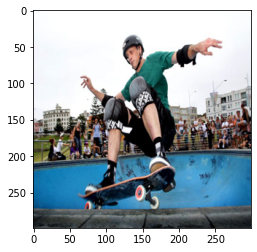

In [28]:
plt.imshow(img)

In [29]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on top of a wooden ramp .
a man in a blue shirt is doing a trick on a skateboard .
a man in a blue shirt riding a skateboard .
a man on a skateboard doing a trick .
a man on a skateboard doing a trick .
a man on a skateboard does a trick on a ramp .
a man on a skateboard doing a trick .
a man riding a skateboard on top of a wooden ramp .
a man on a skateboard doing a trick .
a man on a skateboard doing a trick .


--2021-06-02 17:23:34--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-06-02 17:23:34--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K   214KB/s    in 0.5s    

2021-06-02 17:23:35 (214 KB/s) - ‘data/img.jpg’ saved [106870/106870]



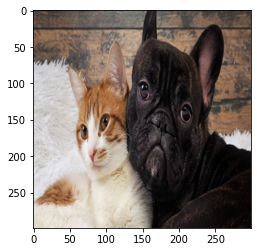

a cat is laying on a couch with a remote .
a black and white dog with a red collar and a red collar on a couch .
a black and white cat is sitting on a white and blue chair
a cat is laying on a couch with a remote control .
a black and white cat sitting on top of a bed .
a black and white cat is sitting on a black couch .
a cat is laying on a couch with a remote control .
a cat is sitting on a couch with a remote control .
a cat is laying on a couch with a remote control .
a cat is sitting on a couch with a remote control .


In [30]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

Theme images:


/home/andyst/anaconda3/envs/pytorch_1.5.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  """


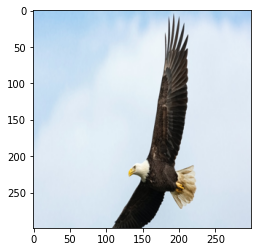

a bird is flying over a body of water .
a bird is flying over a body of water .
a bird is sitting on a branch in a tree .
a bird is sitting on a branch in a field
a bird is sitting on a branch in a field



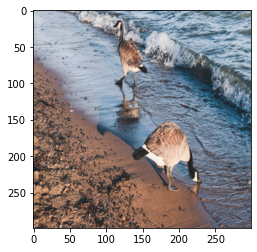

a group of birds standing on top of a grass covered field .
a group of birds standing on top of a grass covered field .
a group of birds standing on top of a grass covered field .
a group of small birds standing on top of a grass covered field .
a group of birds standing on top of a grass covered field .



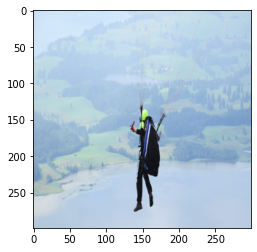

a man standing on top of a snow covered slope .
a man in a blue shirt is riding a snowboard .
a person on a snowboard is in the snow .
a man standing on a snow covered slope with a snowboard .
a man is standing on a hill with a kite



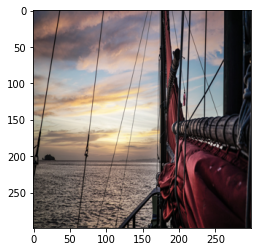

a boat is on the water near a dock .
a boat is in the water by the shore .
a boat that is in the water near the shore .
a boat is on the water near a dock .
a boat that is on the water near a dock



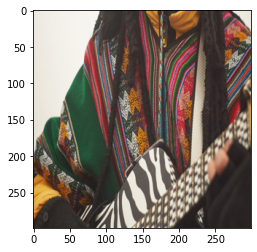

a person wearing a tie and a tie
a person wearing a tie and a tie
a person wearing a tie and a tie
a person wearing a tie and a hat
a person wearing a tie and a tie



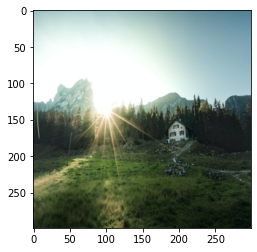

a group of people riding skis on a snowy surface
a group of people standing on top of a lush green hillside .
a man on a skateboard in a field .
a man on a skateboard in the middle of a field .
a man is riding a horse in the middle of a field .



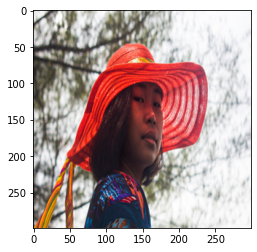

a woman wearing a hat and a hat .
a man wearing a hat and a hat and a hat .
a woman wearing a hat and a hat and a hat .
a woman wearing a hat and a hat on a cell phone .
a woman wearing a hat and a hat and a hat on a cell phone .



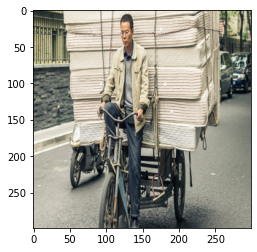

a man riding a motorcycle down a street .
a man riding a motorcycle with a red and white cat on top of it .
a man riding a motorcycle down a street next to a building .
a man riding a bike with a dog on top of it .
a man riding a bike with a man in the back of it .



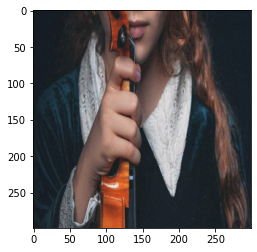

a man with a toothbrush in his mouth .
a woman brushing her teeth with a toothbrush .
a woman with a toothbrush in her mouth .
a woman brushing her teeth with a toothbrush .
a woman with a toothbrush in her mouth .


Random nature images:


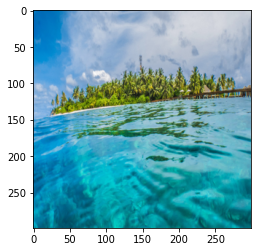

a man riding a surfboard on top of a wave .
a person riding a surfboard on a wave in the ocean .
a person riding a surf board on a wave
a person riding a surfboard in the water .
a man riding a surfboard in the ocean .



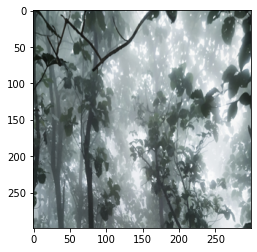

a bunch of birds that are standing in the snow .
a bunch of birds that are standing in the tree .
a group of birds standing on top of a tree branch .
a bunch of birds that are standing in the snow .
a group of birds standing in the woods .



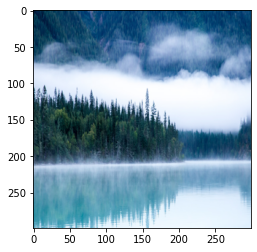

a lone river with a bunch of trees in the background .
a small boat is in the middle of a lake .
a small boat is in the middle of a lake .
a lone river with a small boat in the middle of the river .
a small boat is on the water in the middle of a forest .



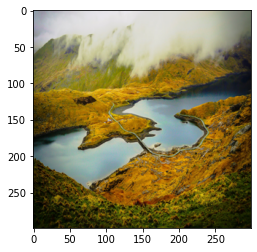

a large rock and a bird on a rocky hill .
a bird flying over the ocean on a cloudy day .
a large rock and a bird on a rocky hill .
a large white and brown bird standing on a rocky cliff .
a large white and blue bird on a rocky mountain .



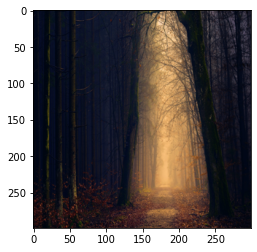

a tall white bird with a black and white background .
a view of a bridge with a clock tower in the background .
a view of a red and red fire hydrant .
a tall tower with a clock on the top of it .
a view of a street with a tall tower with a clock .



Random images:


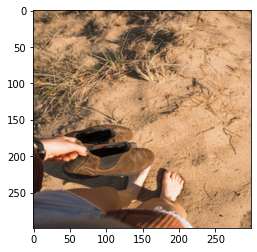

a bird sitting on the ground with a bird .
a person on a beach with a surfboard .
a person sitting on a bench with a bird in the background .
a person laying on a rock with a surfboard .
a person laying on a skateboard on the ground .



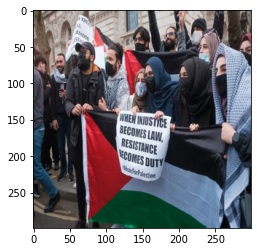

a group of people standing around a large crowd .
a man standing on a street with a motorcycle in the background .
a group of people standing around a motorcycle .
a group of people standing around a motorcycle with a crowd watching .
a man is riding a motorcycle on a street .



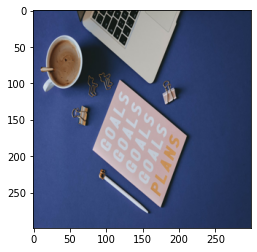

a keyboard and a mouse on a table
a computer keyboard and mouse on a table .
a computer keyboard and mouse on a table .
a laptop computer sitting on top of a table .
a laptop computer sitting on top of a wooden desk .



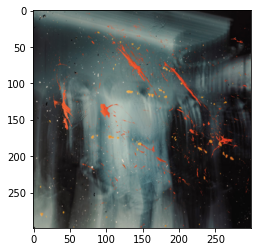

a large black bear walking through a forest .
a large elephant is walking through the woods .
a large elephant standing in the middle of a forest .
a large black bear walking through a forest .
a large black bear walking through a forest .



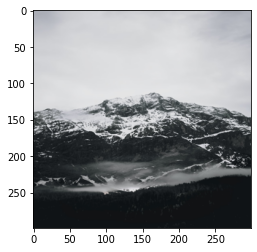

a person riding a snow covered mountain side .
a person riding a snow covered mountain on a snowboard .
a man is skiing down a mountain slope .
a person on a mountain with a mountain in the background .
a person riding a snow covered mountain side .



In [31]:
# apply your network on images you've found
#
#
def show_img(url: str):
    img = plt.imread(url, format="jpg")
    img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(5):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))
    print()

        
img_list = ['bird', 'goose', 'parashute', 'boat', 'poncho', 'sax', 'sombrero', 'tricycle', 'violin']

print("Theme images:")
for img in img_list:
    show_img(f"https://source.unsplash.com/1600x900/?{img}")


print("\nRandom nature images:")
for _ in range(5):
    show_img("https://source.unsplash.com/1600x900/?nature")
print()


print("\nRandom images:")
for _ in range(5):
    show_img("https://source.unsplash.com/random")
    

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)